In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-06-25 22:16:49--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-06-25 22:16:49 (29.0 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## Hyper Parameter

In [ ]:
# --------------------------------------------------------------------------------------------------- #

dataset_path = 'input.txt'
percent_train = 0.90

batch_size = 64
context_length = 256

n_embd = 384
n_layer = 6
num_head = 6
dropout = 0.2

learning_rate = 3e-4
max_iters = 5000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

eval_intervals = 300
eval_iters = 200

# --------------------------------------------------------------------------------------------------- #

## Loading the Dataset

In [ ]:
with open(dataset_path, 'r') as fp:
    dataset = fp.read()

"""## Vocabulary
Creating a vocabulary. Essentially contains all the *tokens* which is recognised by the language model.
"""

vocabulary = sorted(list(set(dataset)))
vocab_size = len(vocabulary)

"""## Encoders and Decoder
We are using a simple method to encode and decode the text data into numbers (integers).
"""

stoi = { ch:i for i, ch in enumerate(vocabulary)}
itos = { i:ch for i, ch in enumerate(vocabulary)}

encode = lambda x: [stoi[ch] for ch in x]
decode = lambda x: ''.join([itos[i] for i in x])

test_text = 'This is a sample sentence.'
assert(test_text == decode(encode(test_text)))

"""## Encoding All the Dataset
We encode all the dataset into numbers.
"""

encoded_dataset = torch.tensor(encode(dataset), dtype=torch.long)

"""## Split Dataset
We split the dataset to train the model and validate the model. Validation is important as we are trying to generalise the model so that it can produce sentences which are "like" the training data but not exactly the training data.
"""

idx = int(len(encoded_dataset) * percent_train)
train_data, val_data = encoded_dataset[:idx], encoded_dataset[idx:]

## Utility Functions

In [ ]:
def get_batch(split):
    data = train_data if split == 'train' else val_data

    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i : i + context_length] for i in ix])
    y = torch.stack([data[i + 1 : i + context_length + 1] for i in ix])

    return x.to(device), y.to(device)


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()

    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = model(xb, yb)

            losses[k] = loss.item()
        out[split] = losses.mean()

    model.train()
    return out

## Implementing Various Parts of a Block

In [ ]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()

        self.head_size = head_size
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = torch.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        return wei @ v


class MultiHeadAttention(nn.Module):
    def __init__(self, num_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_head)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.concat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd, num_head):
        super().__init__()
        head_size = n_embd // num_head
        self.sa = MultiHeadAttention(num_head, head_size)
        self.ffwd = FeedForward(n_embd)

        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # Added Residual Connections
        # We also do pre tranformation normalization
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

## Implementing the Block

In [ ]:
class DecoderTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embeddings_table = nn.Embedding(vocab_size, n_embd)
        self.position_embeddings_table = nn.Embedding(context_length, n_embd)

        # We essentially repeat the above multiple times.
        self.blocks = nn.Sequential(*[Block(n_embd, num_head=num_head) for _ in range(n_layer)])
        self.layernorm = nn.LayerNorm(n_embd)

        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are tensors of shape (Batch Size, Context Length)
        # (B, T)
        B, T = idx.shape

        token_embd = self.token_embeddings_table(idx)  # (B, T, C)
        pos_embd = self.position_embeddings_table(torch.arange(T, device=device))
        x = token_embd + pos_embd

        x = self.blocks(x)
        x = self.layernorm(x)

        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)

            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_next_tokens):
        for _ in range(max_next_tokens):
            idx_cond = idx[:, -context_length:]

            logits, loss = self(idx_cond)

            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)
        return idx

## Training the Model

In [ ]:
model = DecoderTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

all_losses = {'train': [], 'val': []}
t_indent = len(str(max_iters))

for iter in tqdm(range(max_iters)):
    if iter % eval_intervals == 0:
        losses = estimate_loss()
        [all_losses[k].append(losses[k].item()) for k in losses]

        print(f'Iteration[{iter + 1 : >{t_indent}}/{max_iters}], Training Loss: {losses["train"] : .6f}, Validation Loss: {losses["val"]: .6f}')

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    optimizer.step()

print(f'Final Loss:\n\tTraining: {losses["train"] : .6f}\n\tValidation: {losses["val"]: .6f}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Iteration[   1/5000], Training Loss:  4.284884, Validation Loss:  4.282317


  6%|▌         | 301/5000 [04:25<25:55:50, 19.87s/it]

Iteration[ 301/5000], Training Loss:  2.318034, Validation Loss:  2.346339


 12%|█▏        | 601/5000 [07:45<24:12:21, 19.81s/it]

Iteration[ 601/5000], Training Loss:  1.887597, Validation Loss:  2.001162


 18%|█▊        | 901/5000 [11:05<22:32:55, 19.80s/it]

Iteration[ 901/5000], Training Loss:  1.649749, Validation Loss:  1.808277


 24%|██▍       | 1201/5000 [14:25<20:50:02, 19.74s/it]

Iteration[1201/5000], Training Loss:  1.518719, Validation Loss:  1.707229


 30%|███       | 1501/5000 [17:45<19:17:40, 19.85s/it]

Iteration[1501/5000], Training Loss:  1.438506, Validation Loss:  1.638837


 36%|███▌      | 1801/5000 [21:05<17:38:31, 19.85s/it]

Iteration[1801/5000], Training Loss:  1.374999, Validation Loss:  1.586136


 42%|████▏     | 2101/5000 [24:25<15:56:28, 19.80s/it]

Iteration[2101/5000], Training Loss:  1.326871, Validation Loss:  1.560265


 48%|████▊     | 2401/5000 [27:45<14:20:37, 19.87s/it]

Iteration[2401/5000], Training Loss:  1.291204, Validation Loss:  1.539305


 54%|█████▍    | 2701/5000 [31:05<12:39:12, 19.81s/it]

Iteration[2701/5000], Training Loss:  1.255085, Validation Loss:  1.514302


 60%|██████    | 3001/5000 [34:25<11:01:36, 19.86s/it]

Iteration[3001/5000], Training Loss:  1.226632, Validation Loss:  1.507724


 66%|██████▌   | 3301/5000 [37:45<9:20:22, 19.79s/it]

Iteration[3301/5000], Training Loss:  1.200441, Validation Loss:  1.494317


 72%|███████▏  | 3601/5000 [41:05<7:43:05, 19.86s/it]

Iteration[3601/5000], Training Loss:  1.180627, Validation Loss:  1.496876


 78%|███████▊  | 3901/5000 [44:25<6:02:49, 19.81s/it]

Iteration[3901/5000], Training Loss:  1.153252, Validation Loss:  1.488751


 84%|████████▍ | 4201/5000 [47:45<4:23:12, 19.77s/it]

Iteration[4201/5000], Training Loss:  1.129789, Validation Loss:  1.485738


 90%|█████████ | 4501/5000 [51:04<2:44:13, 19.75s/it]

Iteration[4501/5000], Training Loss:  1.106009, Validation Loss:  1.480227


 96%|█████████▌| 4801/5000 [54:24<1:05:30, 19.75s/it]

Iteration[4801/5000], Training Loss:  1.087424, Validation Loss:  1.489692


100%|██████████| 5000/5000 [55:53<00:00,  1.49it/s]

Final Loss:
	Training:  1.087424
	Validation:  1.489692


## Inference


But with prison: I will steal fund to him.
Why says yourself have beat here, say here,
Take as like over. Here's army, provided.

AUFIDIUS:
Here's behovest; a gods answered; he:
So wills make how I have wolved my hand
This lack of true 'Rona's and soonest in her side:
We'll advise to wake it in to fledge,
And clead the new infirmity's broing espice,
My cannot naught men like laughters' seal;
Halping priding woo'd chasemn!
But whither having thy night is dark-likind!
Who chidings: therefore death's descure to do forge,
The records blood to his rich, hath perceiving
Of heartence fould selver the rode.
Beholdmen, lady as our thrifty ride and fear,
Laves as the vyward by walls. I play'd thee sovereign,
See, furse.

Second Peter:
Hold, sir.

Third:
If ever cold to fear thee with thoughts, and two,
The queens of their purpose.

Citizen:
You have traitors!

Turing Roman:
I loved you that so should smook'dst you speak
.

ANGELO:
Why, it were here, an each seen to medy.
Where here steps me no 

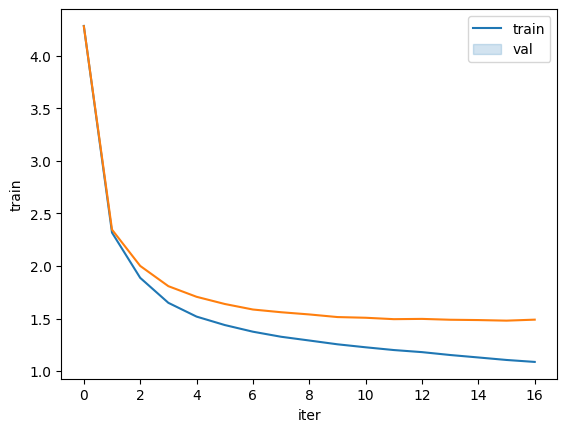

In [ ]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)
generation = decode(model.generate(idx, max_next_tokens=1000)[0].tolist())
print(generation)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
df = pd.DataFrame({
    'iter': range(len(all_losses['train'])),
    'train': all_losses['train'],
    'val': all_losses['val']
})

# Melt the DataFrame to create a "long-form" DataFrame
df_melted = pd.melt(df, id_vars=['iter'], value_vars=['train', 'val'],
                    var_name='loss_type', value_name='loss')

# Create the plot
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='iter', y='loss', hue='loss_type')

plt.title('Training and Validation Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(title='Loss Type')

plt.show()

In [ ]:
torch.save(model, 'tinyGPT.pb')

In [ ]:
new_model = torch.load('tinyGPT.pb')

In [ ]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)
generation = decode(new_model.generate(idx, max_next_tokens=1000)[0].tolist())
print(generation)